<a href="https://colab.research.google.com/github/kadamprasad13/Time-Series-Analysis/blob/main/Time_Series_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
import os
os.environ["kaggle_config_dir"]='/content'
!kaggle datasets download -d kprasad13/time-series
! unzip \*.zip && rm*.zip

Dataset URL: https://www.kaggle.com/datasets/kprasad13/time-series
License(s): unknown
 98% 3.00M/3.06M [00:00<00:00, 26.5MB/s]
100% 3.06M/3.06M [00:00<00:00, 26.8MB/s]
Archive:  time-series.zip
  inflating: train.csv               
/bin/bash: line 1: rm*.zip: command not found


In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Load data
data = pd.read_csv('/content/train.csv', parse_dates=['date'])
data['sales'] = data['sales'].astype(float)
data

,date,store,item,sales
0,2013-01-01,1,1,13.0
1,2013-01-02,1,1,11.0
2,2013-01-03,1,1,14.0
3,2013-01-04,1,1,13.0
4,2013-01-05,1,1,10.0
...,...,...,...,...
912995,2017-12-27,10,50,63.0
912996,2017-12-28,10,50,59.0
912997,2017-12-29,10,50,74.0
912998,2017-12-30,10,50,62.0


**Exploratory Data Analysis**

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 913000 entries, 0 to 912999
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype         
---  ------  --------------   -----         
 0   date    913000 non-null  datetime64[ns]
 1   store   913000 non-null  int64         
 2   item    913000 non-null  int64         
 3   sales   913000 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(2)
memory usage: 27.9 MB


In [4]:
data.describe()

,date,store,item,sales
count,913000,913000.000000,913000.000000,913000.000000
mean,2015-07-02 11:59:59.999999744,5.500000,25.500000,52.250287
min,2013-01-01 00:00:00,1.000000,1.000000,0.000000
25%,2014-04-02 00:00:00,3.000000,13.000000,30.000000
50%,2015-07-02 12:00:00,5.500000,25.500000,47.000000
75%,2016-10-01 00:00:00,8.000000,38.000000,70.000000
max,2017-12-31 00:00:00,10.000000,50.000000,231.000000
std,NaN,2.872283,14.430878,28.801144


In [5]:
unique_values = data.nunique()
print(unique_values)


date     1826
store      10
item       50
sales     213
dtype: int64


**Sales trends over time**

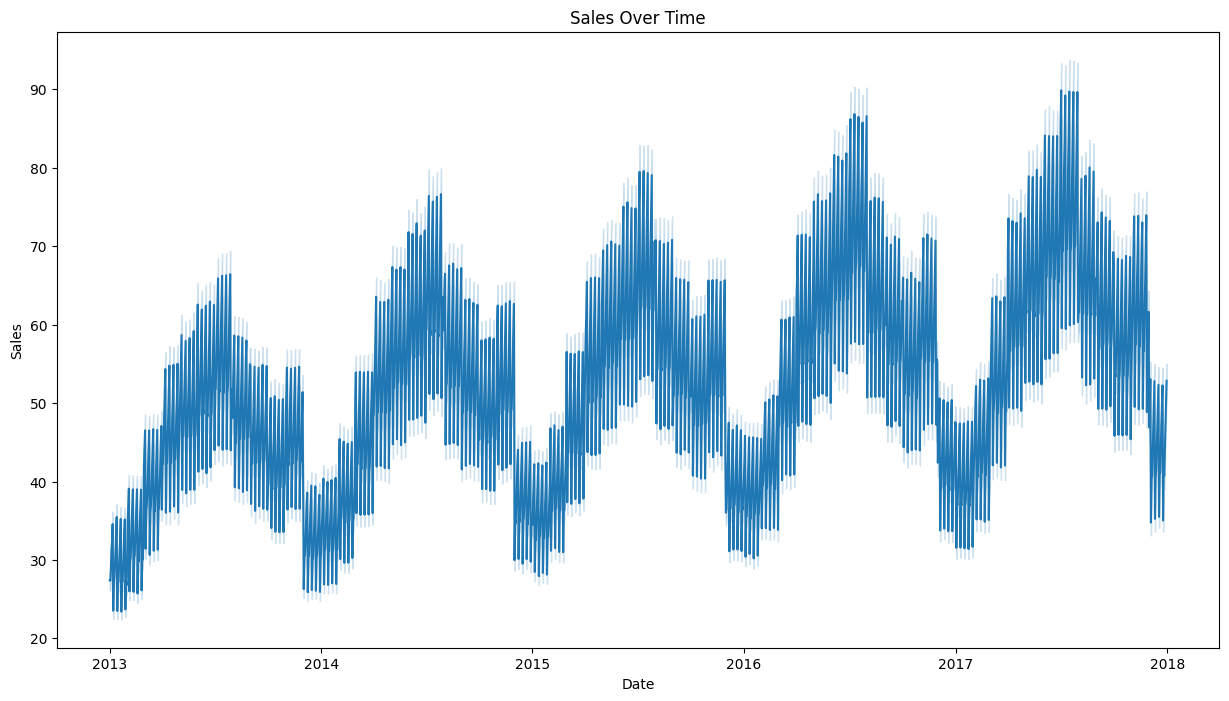

In [6]:
data['date'] = pd.to_datetime(data['date'])

plt.figure(figsize=(15, 8))
sns.lineplot(data=data, x='date', y='sales')
plt.title('Sales Over Time')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.show()


**Sales Distribution by Store and Item**

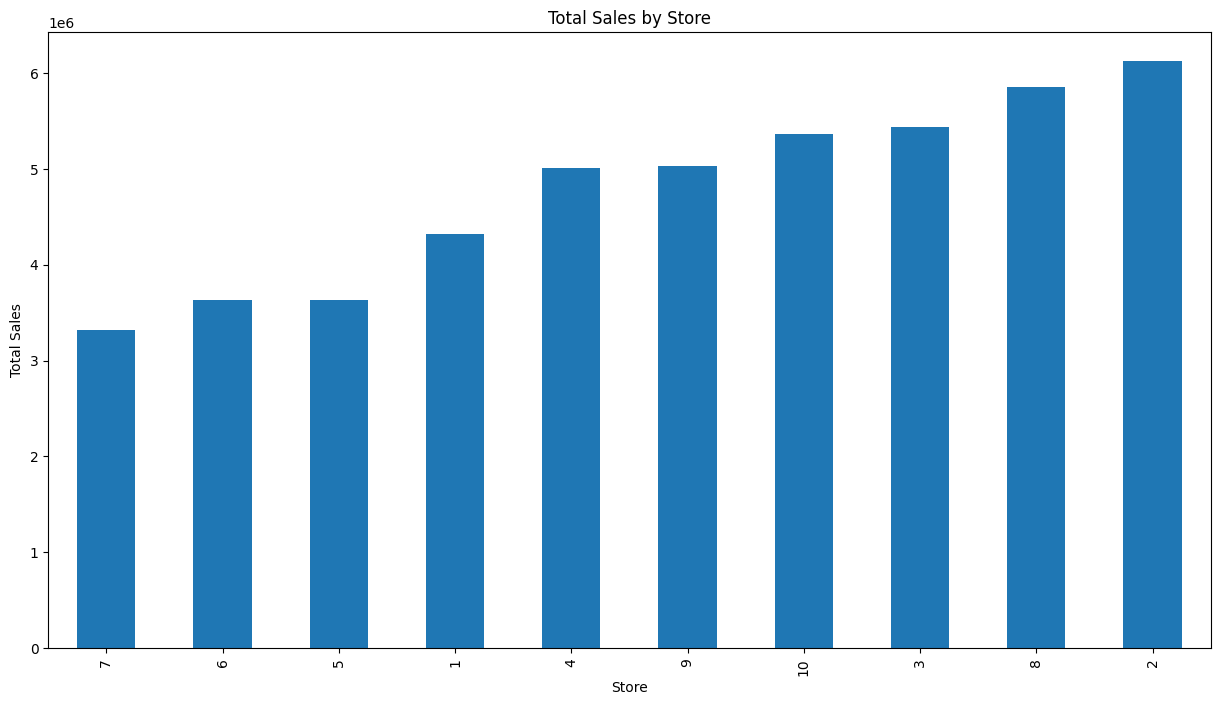

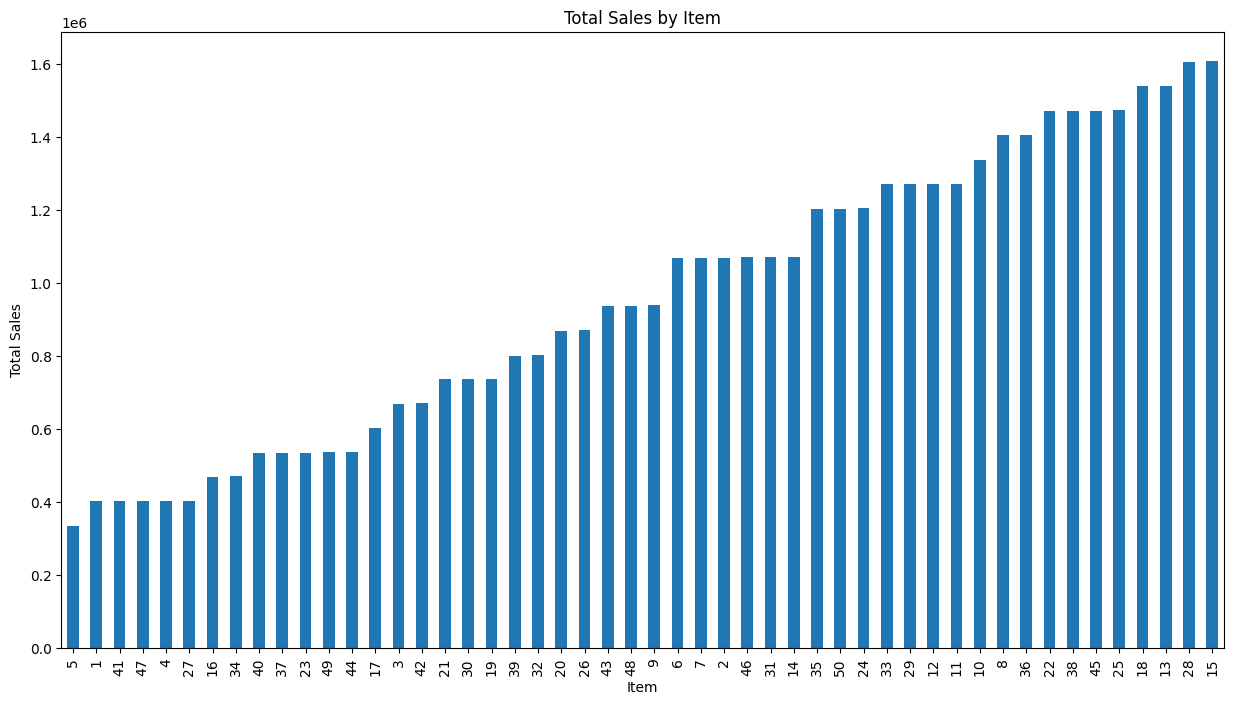

In [7]:

sales_by_store = data.groupby('store')['sales'].sum().sort_values()
sales_by_store.plot(kind='bar', figsize=(15, 8), title='Total Sales by Store')
plt.xlabel('Store')
plt.ylabel('Total Sales')
plt.show()


sales_by_item = data.groupby('item')['sales'].sum().sort_values()
sales_by_item.plot(kind='bar', figsize=(15, 8), title='Total Sales by Item')
plt.xlabel('Item')
plt.ylabel('Total Sales')
plt.show()


In [8]:
# Aggregate sales at the total level
total_sales = data.groupby('date')['sales'].sum().reset_index()
total_sales

,date,sales
0,2013-01-01,13696.0
1,2013-01-02,13678.0
2,2013-01-03,14488.0
3,2013-01-04,15677.0
4,2013-01-05,16237.0
...,...,...
1821,2017-12-27,20378.0
1822,2017-12-28,21885.0
1823,2017-12-29,23535.0
1824,2017-12-30,24988.0


<Figure size 1500x800 with 0 Axes>

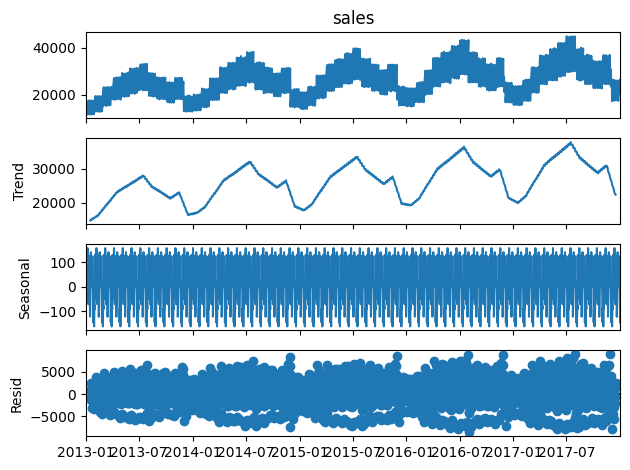

In [9]:
from statsmodels.tsa.seasonal import seasonal_decompose


total_sales.set_index('date', inplace=True)
result = seasonal_decompose(total_sales['sales'], model='additive', period=30)
plt.figure(figsize=(15, 8))
result.plot()
plt.show()


(-3.0602441187013483, 0.029638649268843572, 21, 1804, {'1%': -3.4339800605797155, '5%': -2.8631434696839992, '10%': -2.5676236347535166}, 29234.283115162158)


<Figure size 1200x600 with 0 Axes>

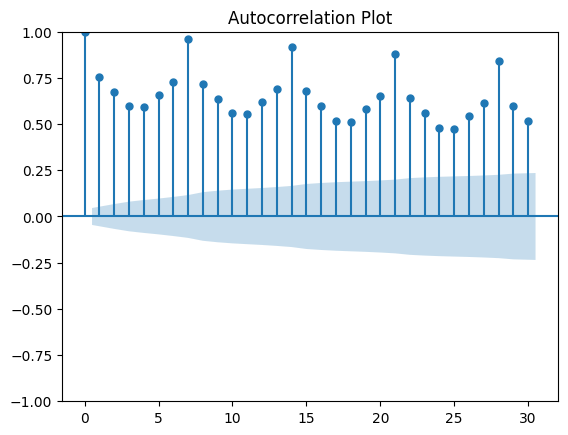

<Figure size 1200x600 with 0 Axes>

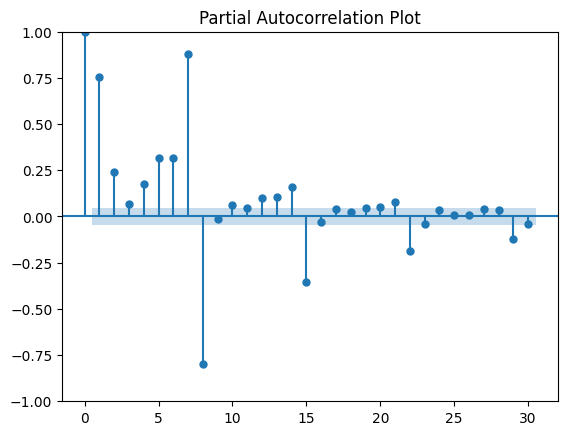

In [10]:
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt
result=adfuller(total_sales['sales'])
print(result)
plt.figure(figsize=(12, 6))
plot_acf(total_sales['sales'], lags=30)
plt.title('Autocorrelation Plot')
plt.show()
plt.figure(figsize=(12, 6))
plot_pacf(total_sales['sales'], lags=30)
plt.title('Partial Autocorrelation Plot')
plt.show()


#ConvLSTM Model

**Feature Engineering**

Creating lag feature with lag of 1 and 7 because the ACF plot shows that data shows very significant auto-correlation at 1st and 7th lag. We are also creating aa trend feature to capture the trend in from the data.

In [ ]:
from sklearn.linear_model import LinearRegression

def create_lag_features(df, lags, column_name='sales'):
    for lag in lags:
        df[f'{column_name}_lag_{lag}'] = df.groupby(['store', 'item'])[column_name].shift(lag)
    return df

lags = [1, 7]
data = create_lag_features(data, lags)
data.fillna(method='ffill', inplace=True)

def calculate_trend(group):
    X = (group['date'] - group['date'].min()).dt.days.values.reshape(-1, 1)
    y = group['sales'].values
    model = LinearRegression().fit(X, y)
    return model.coef_[0]

sales_trend = data.groupby(['store', 'item']).apply(calculate_trend).reset_index().rename(columns={0: 'sales_trend'})
data = data.merge(sales_trend, on=['store', 'item'], how='left')

sales_volatility = data.groupby(['store', 'item'])['sales'].std().reset_index().rename(columns={'sales': 'sales_volatility'})
data = data.merge(sales_volatility, on=['store', 'item'], how='left')

**Preparing the data for training the model**

We are using ConvLSTM for prediction which expects the input in 5D format like (Batch_size,sequence_length, num_store,num_item, channel) so we have to frame the data in the right format that is acceptable to the model layer as input. We are taking the sequence of past 15 sales values as input for the next day prediction.

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler


sales_scaler = MinMaxScaler()
data['sales'] = sales_scaler.fit_transform(data[['sales']])


scaler = MinMaxScaler()
numerical_cols = [f'sales_lag_{lag}' for lag in lags] + ['sales_trend', 'sales_volatility']
data[numerical_cols] = scaler.fit_transform(data[numerical_cols])


features = ['sales'] + numerical_cols
pivoted_data_with_features = data.pivot_table(values=features, index=['store', 'item'], columns='date')
pivoted_data_with_features = pivoted_data_with_features.fillna(0).values.reshape(len(data['store'].unique()), len(data['item'].unique()), -1)

num_dates = pivoted_data_with_features.shape[2]
sequence_length = 15
X = []
y = []

for i in range(num_dates - sequence_length):
    sequence_X = pivoted_data_with_features[:, :, i:i+sequence_length]
    X.append(sequence_X.reshape(sequence_length, pivoted_data_with_features.shape[0], pivoted_data_with_features.shape[1], 1))
    next_day_y = pivoted_data_with_features[:, :, i+sequence_length]
    y.append(next_day_y)

X = np.array(X)
y = np.array(y)

y = y.reshape(y.shape[0], -1)

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

y_train_reshaped = y_train.reshape(y_train.shape[0], -1)
y_val_reshaped = y_val.reshape(y_val.shape[0], -1)


print(f'Shape of X: {X_train.shape}')
print(f'Shape of pivoted_data_with_features: {pivoted_data_with_features.shape}')


Shape of X: (7292, 15, 10, 50, 1)
Shape of pivoted_data_with_features: (10, 50, 9130)


**Training the model**

In [ ]:
from keras.models import Sequential
from keras.layers import ConvLSTM2D, Dense, Flatten, Dropout, Bidirectional, BatchNormalization
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
import tensorflow as tf

model = Sequential()
model.add(Bidirectional(ConvLSTM2D(filters=128, kernel_size=(1, 1), activation='relu', return_sequences=True, input_shape=(sequence_length, X_train.shape[1], X_train.shape[2], 1))))
model.add(BatchNormalization())
model.add(Bidirectional(ConvLSTM2D(filters=64, kernel_size=(1, 1), activation='relu')))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(X_train.shape[2] * X_train.shape[3]))  # Output layer
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='mse')


early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)


model.fit(X_train, y_train_reshaped, epochs=20, batch_size=16, validation_data=(X_val, y_val_reshaped), callbacks=[early_stopping])
model.save('Timeseries_model.h5')

Epoch 1/20
456/456 [==============================] - 217s 425ms/step - loss: 0.0157 - val_loss: 0.0428
Epoch 2/20
456/456 [==============================] - 197s 433ms/step - loss: 0.0035 - val_loss: 0.0015
Epoch 3/20
456/456 [==============================] - 220s 483ms/step - loss: 0.0027 - val_loss: 7.8636e-04
Epoch 4/20
456/456 [==============================] - 212s 465ms/step - loss: 0.0021 - val_loss: 8.1587e-04
Epoch 5/20
456/456 [==============================] - 225s 494ms/step - loss: 0.0019 - val_loss: 8.5880e-04
Epoch 6/20
456/456 [==============================] - 208s 456ms/step - loss: 0.0018 - val_loss: 8.3360e-04


**Predicting on the model**

In [53]:
from sklearn.metrics import r2_score,mean_squared_error

y_val_pred = model.predict(X_val)
print(f'Shape of y_val_pred: {y_val_pred.shape}')
print(f'Shape of y_val: {y_val.shape}')

y_val_pred_reshaped = y_val_pred.reshape(-1, 1)
y_val_reshaped = y_val.reshape(-1, 1)

y_val_pred_inverse = sales_scaler.inverse_transform(y_val_pred_reshaped).reshape(y_val_pred.shape)
y_val_inverse = sales_scaler.inverse_transform(y_val_reshaped).reshape(y_val.shape)

rmse = np.sqrt(mean_squared_error(y_val_inverse, y_val_pred_inverse))
print(f'RMSE: {rmse}')

print(r2_score(y_val_inverse, y_val_pred_inverse))

57/57 [==============================] - 10s 180ms/step
Shape of y_val_pred: (1823, 500)
Shape of y_val: (1823, 500)
RMSE: 6.477743023033259
0.8055248836090235


**Plotting predicted v/s actual sales values**

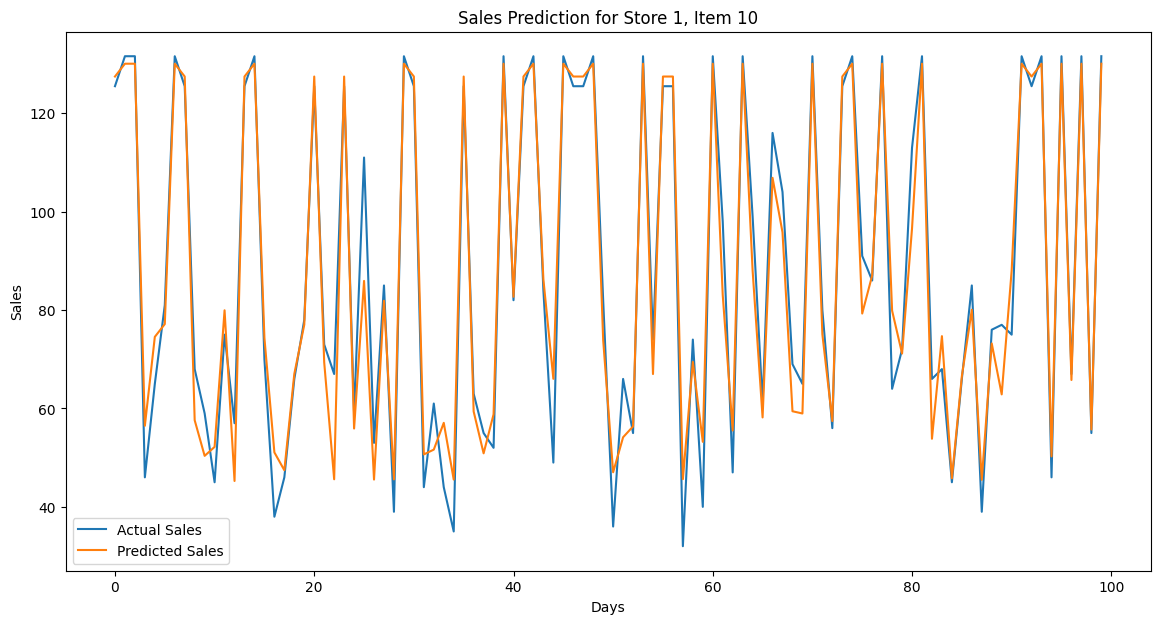

In [22]:
# Reshape y_val_inverse and y_val_pred_inverse back to the original dimensions
num_samples, num_stores, num_items = X_val.shape[0], len(data['store'].unique()), len(data['item'].unique())
y_val_inverse_reshaped = y_val_inverse.reshape(num_samples, num_stores, num_items)
y_val_pred_inverse_reshaped = y_val_pred_inverse.reshape(num_samples, num_stores, num_items)

import matplotlib.pyplot as plt

# Select a particular store and item combination
store_id = 1  # Replace with the desired store ID
item_id = 10   # Replace with the desired item ID

# Extract the index for the chosen store and item
store_index = data['store'].unique().tolist().index(store_id)
item_index = data['item'].unique().tolist().index(item_id)

# Extract the actual and predicted sales for the store and item
actual_sales = y_val_inverse_reshaped[:, store_index, item_index]
predicted_sales = y_val_pred_inverse_reshaped[:, store_index, item_index]

# Select the last 100 days
last_100_days_actual = actual_sales[-100:]
last_100_days_predicted = predicted_sales[-100:]

# Plot the results
plt.figure(figsize=(14, 7))
plt.plot(last_100_days_actual, label='Actual Sales')
plt.plot(last_100_days_predicted, label='Predicted Sales')
plt.xlabel('Days')
plt.ylabel('Sales')
plt.title(f'Sales Prediction for Store {store_id}, Item {item_id}')
plt.legend()
plt.show()


# XGBoost Model

Creating the item_sales a new dataset by grouping the date,store, and item w.r.t. sales

In [12]:
import pandas as pd
data = pd.read_csv('/content/train.csv', parse_dates=['date'])
data['sales'] = data['sales'].astype(float)
item_sales = data.groupby(['date', 'store', 'item'])['sales'].sum().reset_index()
item_sales

,date,store,item,sales
0,2013-01-01,1,1,13.0
1,2013-01-01,1,2,33.0
2,2013-01-01,1,3,15.0
3,2013-01-01,1,4,10.0
4,2013-01-01,1,5,11.0
...,...,...,...,...
912995,2017-12-31,10,46,70.0
912996,2017-12-31,10,47,22.0
912997,2017-12-31,10,48,60.0
912998,2017-12-31,10,49,42.0


In [13]:
def create_date_features(df):
    df['day_of_week'] = df['date'].dt.dayofweek
    df['day_of_month'] = df['date'].dt.day
    df['week_of_year'] = df['date'].dt.isocalendar().week
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    return df

item_sales = create_date_features(item_sales)


We developing functions to extract the cyclic features from the date-time features.

In [14]:

def add_cyclic_features(df, col, max_val):
    df[col + '_sin'] = np.sin(2 * np.pi * df[col] / max_val)
    df[col + '_cos'] = np.cos(2 * np.pi * df[col] / max_val)
    return df

def add_lag_rolling_features(df, lag_days, window_days):
    # Create lag features
    for lag in lag_days:
        df[f'sales_lag_{lag}'] = df.groupby(['store', 'item'])['sales'].shift(lag)

    for window in window_days:
        df[f'sales_roll_mean_{window}'] = df.groupby(['store', 'item'])['sales'].shift(1).rolling(window=window).mean()

    for window in window_days:
        df[f'sales_roll_std_{window}'] = df.groupby(['store', 'item'])['sales'].shift(1).rolling(window=window).std()

    return df

We are creating lag features where the data is showing significant auto-correlation.

In [15]:
lag_days = [1, 7, 14, 28, 35]
window_days = [7, 14, 28, 30, 180, 365]

item_sales = add_lag_rolling_features(item_sales, lag_days, window_days)

item_sales = add_cyclic_features(item_sales, 'day_of_week', 7)
item_sales = add_cyclic_features(item_sales, 'month', 12)
item_sales = item_sales.drop(columns=['day_of_week', 'month']).dropna()



# Prepare the new item-level data
features = ['store', 'item', 'year'] + [f'sales_lag_{lag}' for lag in lag_days] + [f'sales_roll_std_{window}' for window in window_days] + ['day_of_week_sin', 'day_of_week_cos', 'month_sin', 'month_cos']
X_item = item_sales[features]
y_item = item_sales['sales']

Developing feature showing interaction between stores and items. Also target encoding stores and items features.

In [16]:
mean_sales = item_sales.groupby(['store', 'item'])['sales'].mean().reset_index().rename(columns={'sales': 'mean_sales'})
item_sales = item_sales.merge(mean_sales, on=['store', 'item'], how='left')

total_sales = data.groupby(['store', 'item'])['sales'].sum().reset_index().rename(columns={'sales': 'total_sales'})
data = data.merge(total_sales, on=['store', 'item'], how='left')


Building the Xgboost model

In [17]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import joblib


features = ['store', 'item', 'year'] + [f'sales_lag_{lag}' for lag in lag_days] + \
           [f'sales_roll_std_{window}' for window in window_days] + \
           ['day_of_week_sin', 'day_of_week_cos', 'month_sin', 'month_cos']
X_item = item_sales[features]
y_item = item_sales['sales']


lag_scaler = MinMaxScaler()
target_scaler = MinMaxScaler()


X_item_scaled = X_item.copy()
X_item_scaled[[f'sales_lag_{lag}' for lag in lag_days] + [f'sales_roll_std_{window}' for window in window_days]] = lag_scaler.fit_transform(X_item[[f'sales_lag_{lag}' for lag in lag_days] + [f'sales_roll_std_{window}' for window in window_days]])


y_item_scaled = target_scaler.fit_transform(y_item.values.reshape(-1, 1))


X_train_item, X_test_item, y_train_item, y_test_item = train_test_split(X_item_scaled, y_item_scaled, test_size=0.2, random_state=42)


model_item = XGBRegressor(
    n_estimators=1000,
    learning_rate=0.1,
    reg_alpha=0.8,
    reg_lambda=0.2,
    random_state=42
)
model_item.fit(X_train_item, y_train_item.ravel())


joblib.dump(model_item, 'xgboost_model.pkl')

['xgboost_model.pkl']

Predicting the values and calculating the performance metrics.

In [18]:

item_sales['predicted_scaled'] = model_item.predict(X_item_scaled)

y_item_scaled_array = y_item_scaled.reshape(-1, 1)
predicted_scaled_array = item_sales['predicted_scaled'].values.reshape(-1, 1)

rmse_scaled = np.sqrt(mean_squared_error(y_item_scaled_array, predicted_scaled_array))
print(f"RMSE (scaled): {rmse_scaled}")

predicted_original = target_scaler.inverse_transform(predicted_scaled_array).flatten()

sales_original = target_scaler.inverse_transform(y_item_scaled_array).flatten()

item_sales['sales_original'] = sales_original
item_sales['predicted_original'] = predicted_original

rmse_original = np.sqrt(mean_squared_error(item_sales['sales_original'], item_sales['predicted_original']))
print(f"RMSE (original scale): {rmse_original}")

r2_original = r2_score(item_sales['sales_original'], item_sales['predicted_original'])
print(f"R2 score (original scale): {r2_original}")


RMSE (scaled): 0.0324813695697331
RMSE (original scale): 7.503196372665928
R2 score (original scale): 0.9322591280551503


In [19]:
def smape(y_true, y_pred):
    return 100 * np.mean(np.abs(y_true - y_pred) / (np.abs(y_true) + np.abs(y_pred)))

smape_score = smape(item_sales['sales_original'], item_sales['predicted_original'])
print(f"sMAPE: {smape_score}")


sMAPE: 6.485703935440888


Plotting the Predicted_Values v/s Actual_Values

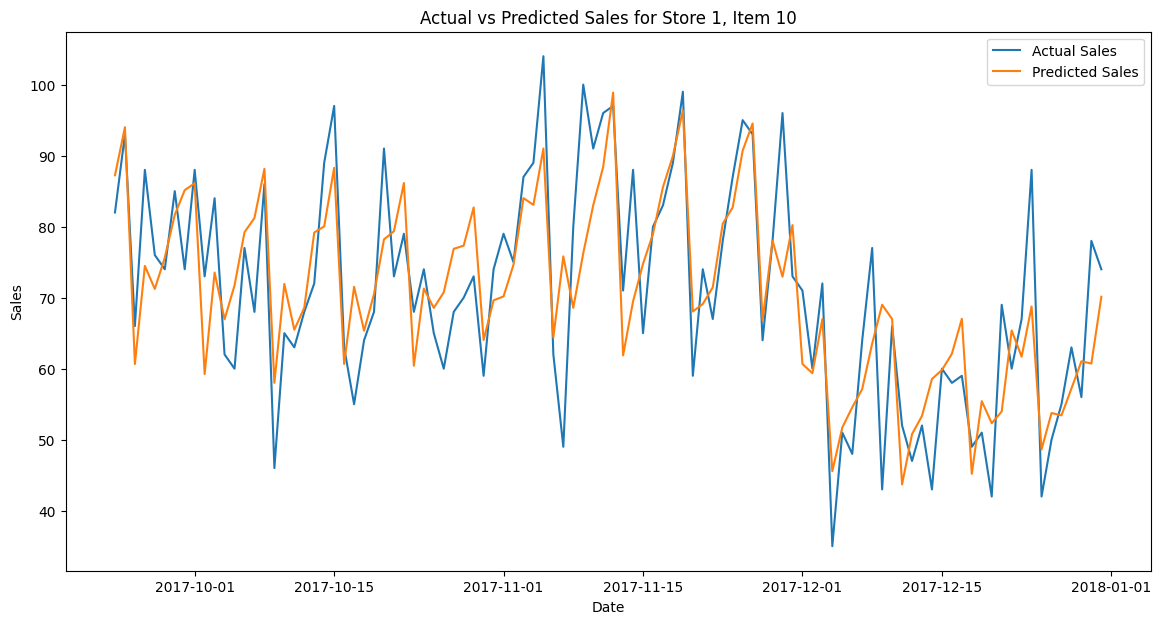

In [22]:
import matplotlib.pyplot as plt

store_id = 1
item_id = 10

store_item_data = item_sales[(item_sales['store'] == store_id) & (item_sales['item'] == item_id)]

if store_item_data.empty:
    print(f"No data found for store {store_id} and item {item_id}")
else:

    store_item_data = store_item_data.sort_values('date')

    last_100_days_data = store_item_data.tail(100)

    plt.figure(figsize=(14, 7))
    plt.plot(last_100_days_data['date'], last_100_days_data['sales_original'], label='Actual Sales')
    plt.plot(last_100_days_data['date'], last_100_days_data['predicted_original'], label='Predicted Sales')
    plt.xlabel('Date')
    plt.ylabel('Sales')
    plt.title(f'Actual vs Predicted Sales for Store {store_id}, Item {item_id}')
    plt.legend()
    plt.show()